# Skills Assignment

In [56]:
# Data and the imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
data = pd.read_csv('ScanRecords.csv')
print(data.head())

         Date  Time  Duration PatientType
0  2025-08-01  8.01  0.528592      Type 1
1  2025-08-01  8.42  0.512493      Type 1
2  2025-08-01  8.53  0.414678      Type 1
3  2025-08-01  8.76  0.756534      Type 2
4  2025-08-01  9.19  0.596613      Type 2


In [57]:
# See the counts of Type 1 and Type 2
type_counts = data['PatientType'].value_counts()
print(type_counts)

PatientType
Type 1    356
Type 2    209
Name: count, dtype: int64


In [58]:
# Get average durations for type 1 and type 2
avg_durations = data.groupby('PatientType')['Duration'].agg('mean').round(3)
print(avg_durations)

PatientType
Type 1    0.429
Type 2    0.679
Name: Duration, dtype: float64


In [59]:
# Count arrivals per day and per type
daily_arrivals = (
    data.groupby(['Date', 'PatientType'])
        .size().rename('Arrivals')
        .reset_index()
)

# Mean calls per day (λ) by type
lambda_by_type = daily_arrivals.groupby('PatientType')['Arrivals'].mean().round(3)
print("Average daily arrivals (λ):")
print(lambda_by_type)


Average daily arrivals (λ):
PatientType
Type 1    16.952
Type 2     9.952
Name: Arrivals, dtype: float64


In [60]:
type1 = data[data['PatientType'] == 'Type 1']
type2 = data[data['PatientType'] == 'Type 2']

mu1 = type1['Duration'].mean()
sigma1 = type1['Duration'].std(ddof=1)

print(f"Type 1 — mean duration (μ₁): {mu1:.3f} h")
print(f"Type 1 — std duration (σ₁): {sigma1:.3f} h")


Type 1 — mean duration (μ₁): 0.429 h
Type 1 — std duration (σ₁): 0.097 h


count    209.000
mean       0.679
std        0.201
min        0.286
25%        0.537
50%        0.651
75%        0.807
max        1.374
Name: Duration, dtype: float64


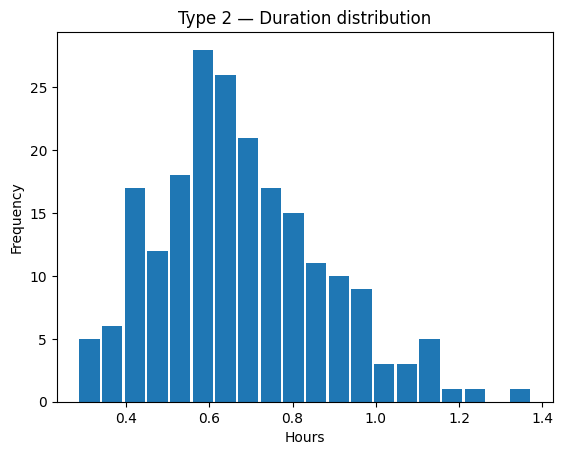

In [61]:
type2 = data[data['PatientType'] == 'Type 2']
print(type2['Duration'].describe().round(3))

# Optional: quick histogram
import matplotlib.pyplot as plt
plt.hist(type2['Duration'], bins=20, rwidth=0.9)
plt.title("Type 2 — Duration distribution")
plt.xlabel("Hours")
plt.ylabel("Frequency")
plt.show()


In [62]:
lam1 = float(lambda_by_type.loc['Type 1'])

rng = np.random.default_rng(42)

def bootstrap_type1(mu, sigma, lam, B=1000):
    rows = []
    for _ in range(B):
        calls = rng.poisson(lam)
        durations = rng.normal(mu, sigma, size=max(calls, 1))
        durations = np.clip(durations, 0, None)  # no negative scan times
        rows.append({
            "calls": calls,
            "mean_dur": durations.mean(),
            "p95_dur": np.quantile(durations, 0.95),
            "total_hours": durations.sum()
        })
    return pd.DataFrame(rows)

boot1 = bootstrap_type1(mu1, sigma1, lam1, B=1000)

# Quick summary table
boot1_summary = boot1.describe(percentiles=[0.05, 0.5, 0.95]).T.round(3)
print(boot1_summary)

              count    mean    std    min      5%     50%     95%     max
calls        1000.0  16.806  4.142  6.000  10.000  17.000  24.000  34.000
mean_dur     1000.0   0.428  0.025  0.326   0.388   0.427   0.469   0.520
p95_dur      1000.0   0.565  0.041  0.398   0.499   0.563   0.631   0.708
total_hours  1000.0   7.196  1.821  2.378   4.405   7.129  10.341  14.472


In [63]:
print("Type 2 Duration Summary:")
print(type2['Duration'].describe().round(3))

Type 2 Duration Summary:
count    209.000
mean       0.679
std        0.201
min        0.286
25%        0.537
50%        0.651
75%        0.807
max        1.374
Name: Duration, dtype: float64


In [64]:
rng = np.random.default_rng(42)
B = 1000  # bootstrap replications

boot2 = pd.DataFrame({
    "mean_dur": [
        type2['Duration'].sample(frac=1, replace=True, random_state=rng).mean()
        for _ in range(B)
    ],
    "p95_dur": [
        np.quantile(type2['Duration'].sample(frac=1, replace=True, random_state=rng), 0.95)
        for _ in range(B)
    ],
    "total_hours": [
        type2['Duration'].sample(frac=1, replace=True, random_state=rng).sum()
        for _ in range(B)
    ]
})

boot2_summary = boot2.describe(percentiles=[0.05, 0.5, 0.95]).T.round(3)
print("\nType 2 Bootstrap Summary:")
print(boot2_summary)


Type 2 Bootstrap Summary:
              count     mean    std      min       5%      50%      95%  \
mean_dur     1000.0    0.679  0.014    0.633    0.656    0.678    0.701   
p95_dur      1000.0    1.039  0.049    0.921    0.974    1.036    1.124   
total_hours  1000.0  141.880  2.894  132.842  137.320  141.736  146.719   

                 max  
mean_dur       0.722  
p95_dur        1.132  
total_hours  152.995  


In [65]:
import scipy.stats as st

fits = {
    "lognorm": st.lognorm.fit(type2['Duration']),
    "gamma":   st.gamma.fit(type2['Duration']),
    "weibull": st.weibull_min.fit(type2['Duration'])
}
print("\nCandidate fits (shape, loc, scale):")
for k,v in fits.items():
    print(k, "→", np.round(v,3))



Candidate fits (shape, loc, scale):
lognorm → [ 0.222 -0.22   0.877]
gamma → [8.772 0.08  0.068]
weibull → [2.193 0.26  0.472]



Candidate fits (shape, loc, scale):
lognorm → [ 0.222 -0.22   0.877]
gamma → [8.772 0.08  0.068]
weibull_min → [2.193 0.26  0.472]


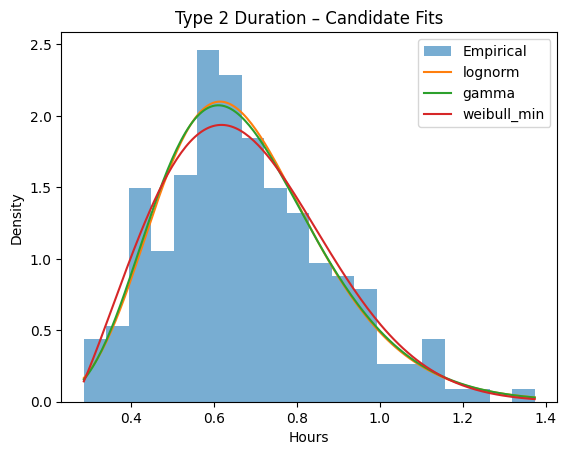

In [67]:
# Fit candidate distributions to Type 2 durations
fits = {
    "lognorm": st.lognorm.fit(type2['Duration']),
    "gamma":   st.gamma.fit(type2['Duration']),
    "weibull_min": st.weibull_min.fit(type2['Duration'])
}

print("\nCandidate fits (shape, loc, scale):")
for k, v in fits.items():
    print(k, "→", np.round(v, 3))

# Plot empirical histogram and fitted PDFs
x = np.linspace(type2['Duration'].min(), type2['Duration'].max(), 200)
plt.hist(type2['Duration'], bins=20, density=True, alpha=0.6, label='Empirical')

for dist_name, params in fits.items():
    shape, loc, scale = params
    dist = getattr(st, dist_name)
    plt.plot(x, dist.pdf(x, shape, loc, scale), label=dist_name)

plt.title("Type 2 Duration – Candidate Fits")
plt.xlabel("Hours")
plt.ylabel("Density")
plt.legend()
plt.show()

In [68]:
summary_table = pd.DataFrame({
    "Type": ["Type 1", "Type 2"],
    "Arrival Model": ["Poisson(λ₁)", "Empirical"],
    "λ (calls/day)": [lambda_by_type.loc['Type 1'], np.nan],
    "Duration Model": ["Normal(μ₁,σ₁²)", "Nonparametric / Lognormal?"],
    "Mean Duration (h)": [mu1, boot2['mean_dur'].mean()],
    "SD (h)": [sigma1, type2['Duration'].std()],
    "95th Percentile (h)": [boot1['p95_dur'].mean(), boot2['p95_dur'].mean()],
    "Mean Total Hours/Day": [boot1['total_hours'].mean(), boot2['total_hours'].mean()]
}).round(3)

print("\n=== Part I Summary Table ===")
print(summary_table)



=== Part I Summary Table ===
     Type Arrival Model  λ (calls/day)              Duration Model  \
0  Type 1   Poisson(λ₁)         16.952              Normal(μ₁,σ₁²)   
1  Type 2     Empirical            NaN  Nonparametric / Lognormal?   

   Mean Duration (h)  SD (h)  95th Percentile (h)  Mean Total Hours/Day  
0              0.429   0.097                0.565                 7.196  
1              0.679   0.201                1.039               141.880  
